In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
puntajes = pd.read_csv("A_INSCRITOS_PUNTAJES_2023_PAES_PUB_MRUN.csv", sep=";")
puntajes.head()

/var/folders/yk/33518yf94tv1yp1xr6r_3n9h0000gn/T/ipykernel_99433/401290949.py:1: DtypeWarning: Columns (17,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  puntajes = pd.read_csv("A_INSCRITOS_PUNTAJES_2023_PAES_PUB_MRUN.csv", sep=";")


,MRUN,ANYO_PROCESO,COD_SEXO,FECHA_NACIMIENTO,RBD,CODIGO_ENS,LOCAL_EDUCACIONAL,UNIDAD_EDUCATIVA,NOMBRE_UNIDAD_EDUC,RAMA_EDUCACIONAL,...,PRUEBA_INV_CQUI,FORMA_INV_CQUI,CORRECTAS_INV_CQUI,ERRADAS_INV_CQUI,OMITIDAS_INV_CQUI,PRUEBA_INV_CTP,FORMA_INV_CTP,CORRECTAS_INV_CTP,ERRADAS_INV_CTP,OMITIDAS_INV_CTP
0,3703667,2023,1,194708,5654,310,1747,1,INSTITUTO CLARET,H1,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
1,8437289,2023,1,194503,40407,363,3997,1,CENTRO DE ESTUDIOS BORDEMAR,H2,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
2,17372901,2023,1,194612,3645,363,1514,1,LICEO VIDA NUEVA,H2,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
3,16702090,2023,2,200308,109,610,25,4,COLEGIO DEPORTIVO TEC. PROF. ELENA DUVAUCHELLE...,T3,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
4,22654139,2023,2,194507,3003,363,1450,2,COLEGIO PIAGET,H2,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0


In [3]:
socioeconomic = pd.read_csv("B_SOCIOECONOMICO_DOMICILIO_2023_PAES_PUB_MRUN.csv", sep=";")
socioeconomic.head()

,MRUN,ANYO_PROCESO,CODIGO_REGION_DOMICILIO,CODIGO_PROVINCIA_DOMICILIO,CODIGO_COMUNA_DOMICILIO,NOMBRE_COMUNA_DOMICILIO,SEXO,FECHA_NACIMIENTO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,...,USO_ESPACIO_1,USO_ESPACIO_2,USO_ESPACIO_3,USO_ESPACIO_4,USO_ESPACIO_5,USO_ESPACIO_6,USO_ESPACIO_7,USO_ESPACIO_8,TRANQUILIDAD_COLEGIO,TRABAJO_GRUPO_COLEGIO
0,3703667,2023,9,91,9101,TEMUCO,1,194708,8,1,...,0,0,0,0,0,0,0,0,9,9
1,8437289,2023,5,55,5506,NOGALES,1,194503,6,2,...,0,2,0,0,0,0,0,0,4,4
2,17372901,2023,16,161,16101,CHILLAN,1,194612,5,6,...,0,0,0,0,0,0,2,2,1,1
3,16702090,2023,1,11,1101,IQUIQUE,2,200308,3,2,...,0,2,0,0,0,0,0,1,2,5
4,22654139,2023,7,71,7105,MAULE,2,194507,5,5,...,0,0,0,0,0,0,0,0,9,9


In [4]:
new_1 = socioeconomic.drop(['FECHA_NACIMIENTO','ANYO_PROCESO', 'CODIGO_REGION_DOMICILIO','CODIGO_PROVINCIA_DOMICILIO','CODIGO_COMUNA_DOMICILIO','NOMBRE_COMUNA_DOMICILIO'], axis=1)
#quite ciertos datos de socioeconomic que no ibamos a usar :p

In [5]:
columnas_puntajes = ['MRUN', 'DEPENDENCIA', 'PROMEDIO_NOTAS','PTJE_NEM','PTJE_RANKING','CLEC_REG_ACTUAL','MATE1_REG_ACTUAL','MATE2_REG_ACTUAL','HCSOC_REG_ACTUAL','CIEN_REG_ACTUAL','PROMEDIO_CM_MAX','CLEC_MAX','MATE1_MAX','MATE2_MAX','HCSOC_MAX','CIEN_MAX']
new_2 = puntajes[columnas_puntajes]
#quite unos datos de puntajes tambien

In [6]:
#merge entre new_1 y new_2
merged_new = pd.merge(new_1,new_2,on='MRUN')
merged_new

,MRUN,SEXO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,DISPOSITIVO_1,DISPOSITIVO_2,DISPOSITIVO_3,DISPOSITIVO_4,DISPOSITIVO_5,USO_DISPOSITIVO_1,...,MATE1_REG_ACTUAL,MATE2_REG_ACTUAL,HCSOC_REG_ACTUAL,CIEN_REG_ACTUAL,PROMEDIO_CM_MAX,CLEC_MAX,MATE1_MAX,MATE2_MAX,HCSOC_MAX,CIEN_MAX
0,3703667,1,8,1,S,N,S,N,N,3,...,846,558,836,748,831,816,846,728,950,748
1,8437289,1,6,2,N,N,S,N,N,0,...,0,0,0,0,0,0,0,0,0,0
2,17372901,1,5,6,N,N,N,S,N,0,...,499,0,0,412,"498,5",498,499,0,0,412
3,16702090,2,3,2,N,N,S,N,N,0,...,0,0,0,0,0,0,0,0,0,0
4,22654139,2,5,5,N,N,N,N,S,0,...,402,413,318,0,383,364,402,413,318,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296807,26526755,1,1,3,N,N,S,N,N,0,...,757,483,0,578,695,633,757,483,0,578
296808,26526694,1,2,3,S,N,S,N,N,2,...,516,313,0,498,"638,5",761,516,386,0,498
296809,26526332,1,1,3,N,N,S,N,N,0,...,480,332,578,500,531,582,480,403,578,500
296810,26525532,1,3,3,S,S,S,N,N,1,...,579,292,565,519,"592,5",606,579,292,565,519


Aquí empieza la limpieza de datos de las columnas de merged_new

In [7]:
tipos_dato = merged_new.dtypes 
print(tipos_dato)

MRUN                           int64
SEXO                           int64
INGRESO_PERCAPITA_GRUPO_FA     int64
RAZON_PRINCIPAL_PAES           int64
DISPOSITIVO_1                 object
DISPOSITIVO_2                 object
DISPOSITIVO_3                 object
DISPOSITIVO_4                 object
DISPOSITIVO_5                 object
USO_DISPOSITIVO_1              int64
USO_DISPOSITIVO_2              int64
USO_DISPOSITIVO_3              int64
HOGAR_CONEXION_INTERNET       object
CONEXION_INSUFICIENTE          int64
ESPACIO_1                     object
ESPACIO_2                     object
ESPACIO_3                     object
ESPACIO_4                     object
ESPACIO_5                     object
ESPACIO_6                     object
ESPACIO_7                     object
ESPACIO_8                     object
ESPACIO_9                     object
USO_ESPACIO_1                  int64
USO_ESPACIO_2                  int64
USO_ESPACIO_3                  int64
USO_ESPACIO_4                  int64
U

In [8]:
import numpy as np

#cambiar las comas por puntos
merged_new['PROMEDIO_CM_MAX'] = merged_new['PROMEDIO_CM_MAX'].str.replace(',', '.').astype(float)
merged_new['PROMEDIO_NOTAS'] = merged_new['PROMEDIO_NOTAS'].str.replace(',', '.').astype(float)

#para todas las columnas que poseen N o S se cambia por 0 o 1
cols = ['DISPOSITIVO_1', 'DISPOSITIVO_2', 'DISPOSITIVO_3', 'DISPOSITIVO_4', 'DISPOSITIVO_5', 'HOGAR_CONEXION_INTERNET', 'ESPACIO_1', 'ESPACIO_2', 'ESPACIO_3', 'ESPACIO_4', 'ESPACIO_5', 'ESPACIO_6', 'ESPACIO_7', 'ESPACIO_8', 'ESPACIO_9']

# Valores distintos a 'N' o 'S' se reemplazan por NaN
for col in cols:
    merged_new[col] = merged_new[col].apply(lambda x: x if x in ['N', 'S'] else np.nan)

# Eliminar los NaN
merged_new.dropna(subset=cols, inplace=True)

# Transformación de tipo
for col in cols:
    merged_new[col] = merged_new[col].str.replace('N', '0').str.replace('S', '1').astype(int)
    print(f"Columna transformada: {col}")

print("\nDataFrame después de la transformación:")
print(merged_new)

Columna transformada: DISPOSITIVO_1
Columna transformada: DISPOSITIVO_2
Columna transformada: DISPOSITIVO_3
Columna transformada: DISPOSITIVO_4
Columna transformada: DISPOSITIVO_5
Columna transformada: HOGAR_CONEXION_INTERNET
Columna transformada: ESPACIO_1
Columna transformada: ESPACIO_2
Columna transformada: ESPACIO_3
Columna transformada: ESPACIO_4
Columna transformada: ESPACIO_5
Columna transformada: ESPACIO_6
Columna transformada: ESPACIO_7
Columna transformada: ESPACIO_8
Columna transformada: ESPACIO_9

DataFrame después de la transformación:
            MRUN  SEXO  INGRESO_PERCAPITA_GRUPO_FA  RAZON_PRINCIPAL_PAES  \
0        3703667     1                           8                     1   
1        8437289     1                           6                     2   
2       17372901     1                           5                     6   
3       16702090     2                           3                     2   
4       22654139     2                           5               

In [9]:
#para los datos Nan que son discretos se cambian a 0, quizas despues puede ser el promedio 
for col in merged_new.select_dtypes(include=['object']).columns:
    merged_new[col] = merged_new[col].replace(' ', '0')
    merged_new[col] = merged_new[col].astype(int)
    print(f"Columna transformada: {col}")

Columna transformada: DEPENDENCIA
Columna transformada: CLEC_REG_ACTUAL
Columna transformada: MATE1_REG_ACTUAL
Columna transformada: MATE2_REG_ACTUAL
Columna transformada: HCSOC_REG_ACTUAL
Columna transformada: CIEN_REG_ACTUAL


Clusters con KMeans

In [10]:
#seleccion de columnas para hacer el cluster 
data2 = merged_new.drop('MRUN',axis=1)
data = merged_new[['PROMEDIO_CM_MAX','RAZON_PRINCIPAL_PAES','USO_DISPOSITIVO_1','USO_DISPOSITIVO_2','USO_DISPOSITIVO_3','CONEXION_INSUFICIENTE','USO_ESPACIO_1','USO_ESPACIO_2','USO_ESPACIO_3','USO_ESPACIO_4','USO_ESPACIO_5','USO_ESPACIO_6','USO_ESPACIO_7','USO_ESPACIO_8','TRANQUILIDAD_COLEGIO','TRABAJO_GRUPO_COLEGIO']]

In [11]:
#revisar cuantos clusters crear
#inertia es SSE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
means = []
inertias = []
def optimize_k_means(data,max_k):
    for k in range(1,max_k):
        k_means = KMeans(n_clusters=k)
        k_means.fit(data)
        means.append(k)
        inertias.append(k_means.inertia_)

    fig = plt.subplots(figsize=(5,5))
    plt.plot(means,inertias, 'o-')
    plt.xlabel('Number Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

In [12]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, f_regression

#se normalizan los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

#se eligen los atributos que se utilizaran para hacer el cluster usando genericunivariateselect, de ahi lo podemos cambiar por otro, esto era para ver si funcionaba xd
y = merged_new['PROMEDIO_CM_MAX']
#se supone que al usar f_regression utiliza la correlacion de pearson para determinar que caracteristicas tienen mayor correlacion con promedio_max,
#selecciona el 50% de caracteristicas con mayor correlacion
#puede usarse percentil o kbest, pero kbest uno determina con un valor fijo
selector = GenericUnivariateSelect(score_func=f_regression, mode='percentile', param=50)
selector.fit(scaled_data, y)
#atributos elegidos
selected_features = selector.transform(scaled_data)
support = selector.get_support()
selected_indices = np.where(support)[0]
#nombre de los atributos elegidos
selected_feature_names = data.columns[selected_indices]
selected_feature_names

Index(['USO_DISPOSITIVO_1', 'CONEXION_INSUFICIENTE', 'USO_ESPACIO_1',
       'USO_ESPACIO_2', 'USO_ESPACIO_3', 'USO_ESPACIO_4', 'USO_ESPACIO_6',
       'USO_ESPACIO_7'],
      dtype='object')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

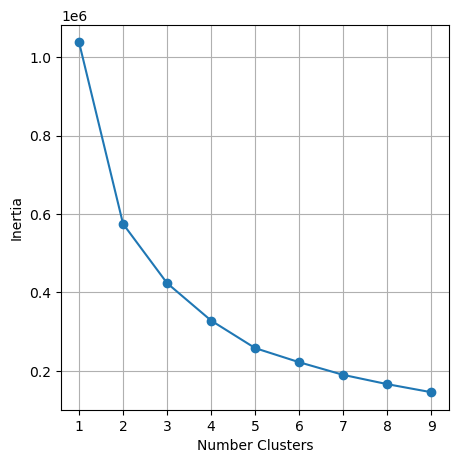

In [13]:
import numpy as np
from sklearn.decomposition import PCA
#se hace un pca para reducir dimensionalidad 
X = selected_features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(selected_features)

#se llama a la funcion para ver cuantos clusters conviene utilizar 
optimize_k_means(X_pca,10)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


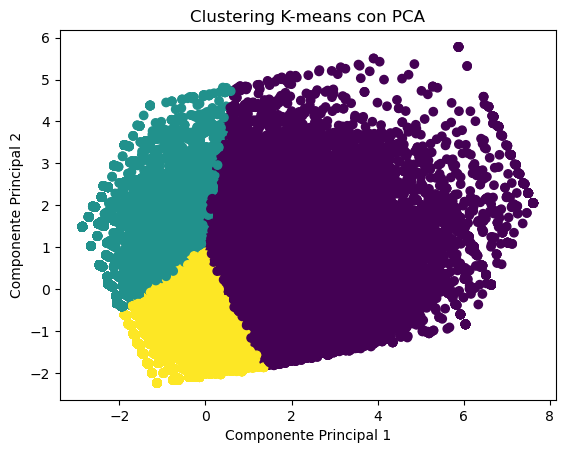

In [14]:
#se hacen dos clusters de kmeans para probar
kmeans = KMeans(n_clusters=3, random_state=0) #se toma el numero de clusters dependiendo del grafico de codo 
kmeans.fit(X_pca)
labels = kmeans.labels_

# Visualizar los clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('Clustering K-means con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()